In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
#Import libraries
import os, glob

import numpy as np
from scipy import integrate
from scipy import interpolate
import scipy
import matplotlib.pyplot as plt 
import matplotlib.cm as cm # colormaps
import matplotlib.colors as mc
import astropy.io.fits as pyfits
from matplotlib.gridspec import GridSpec
import matplotlib as mpl
from matplotlib.ticker import (
    AutoLocator, AutoMinorLocator)
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.axes as maxes

import pandas as pd
import math 
from astropy.table import Table
from astropy.io import ascii
from astropy.wcs import WCS
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.wcs.utils import skycoord_to_pixel
from astropy.visualization.wcsaxes import add_scalebar




from astropy.convolution import Gaussian2DKernel
from scipy.signal import convolve as scipy_convolve
from astropy.convolution import convolve_fft
from scipy import ndimage, misc

#import FITS_tools #https://github.com/keflavich/FITS_tools/tree/master/FITS_tools
from reproject import reproject_interp

/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
##import the star count maps
star_counts_filename = './FITS/nishiyama_counts.fits'
star_counts = pyfits.open('./FITS/nishiyama_counts.fits')[0]                 
star_counts_wcs = WCS(star_counts.header)


counts_err_filename = './FITS/nishiyama_error.fits'
counts_err = pyfits.open('./FITS/nishiyama_error.fits')[0]                 
counts_err_wcs = WCS(counts_err.header)

model_counts_filename = './FITS/model_counts.fits'
model_counts = pyfits.open('./FITS/model_counts.fits')[0]                
model_counts_wcs = WCS(model_counts.header)

#import the full cloud catalog mask
full_cloud_cat_mask_filename = '/Users/danilipman/Documents/Research/UConn/3D_CMZ/FITS/id_mask_mosaic_FULL_zeros.fits'
full_cloud_cat_mask = pyfits.open('/Users/danilipman/Documents/Research/UConn/3D_CMZ/FITS/id_mask_mosaic_FULL_zeros.fits')[0]
full_cloud_cat_mask_wcs = WCS(full_cloud_cat_mask.header)


In [4]:
def gaussian_smoothing(res_want, pix_scale, header, data, filename):
    r_eff = 3 #arcmin
    res = (r_eff/2.355) * 60   
    sig_gauss = np.sqrt(res**2 - res_want**2 )
    kern = sig_gauss/pix_scale #arcsec/pix
    
    smoothed = convolve_fft(data, Gaussian2DKernel(x_stddev=kern), normalize_kernel=True, preserve_nan=True, allow_huge=True)

    pyfits.writeto('{}_smoothed_reff{}arcmin.fits'.format(filename, r_eff), smoothed, header, overwrite=True) 
    
    return smoothed

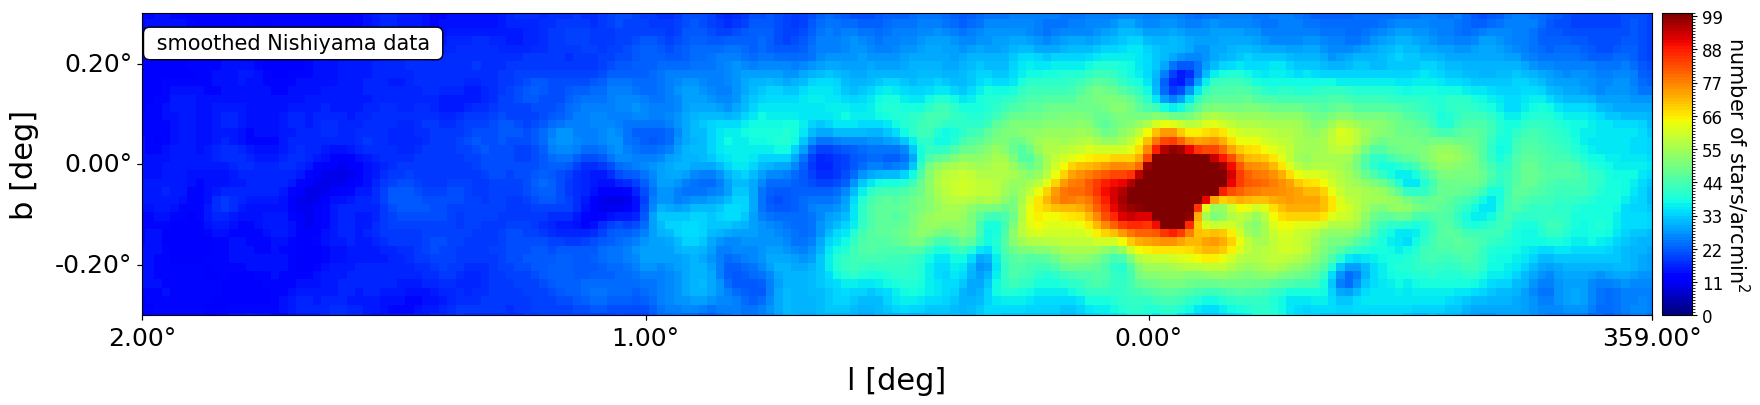

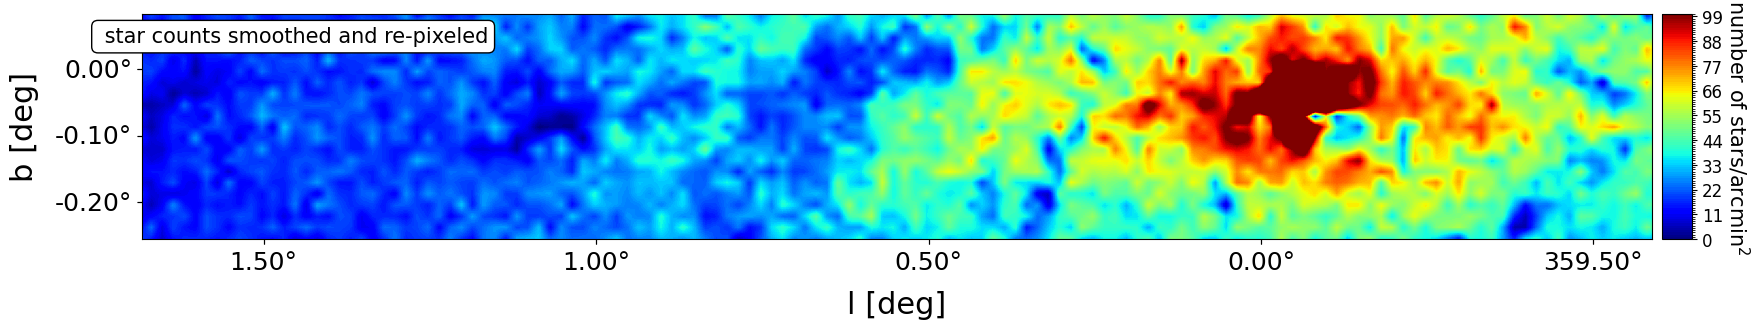

In [5]:
## Smooth the star count and error maps to column density map
sig_colden = 36./2.355 # arcsec
pixscale_colden = 3.2 # arcsec/pix
pixscale_starcount = star_counts.header['CDELT2']*3600
star_count_smoothed = gaussian_smoothing(sig_colden, pixscale_starcount,star_counts.header, star_counts.data, star_counts_filename  )
counts_err_smoothed  = gaussian_smoothing(sig_colden, pixscale_starcount,counts_err.header, counts_err.data, counts_err_filename  )
model_counts_smoothed  = gaussian_smoothing(sig_colden, pixscale_starcount,model_counts.header, model_counts.data, model_counts_filename  )


levels  = np.linspace(0,100,101)
norm    = mc.BoundaryNorm(levels, 256)
cmap    = 'jet'
#extent of plot
ext_min = skycoord_to_pixel(SkyCoord(2, -0.3, unit="deg", frame='galactic'), star_counts_wcs)
ext_max = skycoord_to_pixel(SkyCoord(-1, 0.3, unit="deg", frame='galactic'), star_counts_wcs)

fig, ax = plt.subplots(nrows=1, subplot_kw={'projection': star_counts_wcs}, figsize = (20,4), sharex=True, sharey=True)

IM = ax.imshow(star_count_smoothed.data,cmap='jet',norm =norm, origin='lower')
lon = ax.coords[0]
lat = ax.coords[1]
lon.set_major_formatter('d.dd')
lat.set_major_formatter('d.dd')
lon.set_ticks_position('b')
lon.set_ticklabel_position('b')
lon.set_axislabel_position('b')
lat.set_ticks_position('l')
lat.set_ticklabel_position('l')
lat.set_axislabel_position('l')
ax.set_xlabel('l [deg]',fontsize=22)
ax.set_ylabel('b [deg]',fontsize=22)
ax.set_xlim(ext_min[0],ext_max[0])
ax.set_ylim(ext_min[1],ext_max[1])
ax.tick_params(labelsize=18) 
ax.text(0.1, 0.90, r' smoothed Nishiyama data ', ha='center', va='center', transform=ax.transAxes,
           bbox=dict(boxstyle = 'round', facecolor='white', edgecolor='k', alpha=1), fontsize=15)

divider1 = make_axes_locatable(ax)
cax1 = divider1.append_axes("right", size="2%", pad=0.1,  axes_class=maxes.Axes)
cb1 = fig.colorbar(IM, orientation="vertical", cax = cax1)
cb1.set_label(label = r'number of stars/arcmin$^{2}$', labelpad=20, y=0.5, rotation=-90, fontsize = 15)
cb1.ax.tick_params(labelsize=12)




## re-pixel smoothed star count, regular star count, error map, and model to column density map (i.e. it matches the mask) 
star_count_smoothed = pyfits.open('{}_smoothed_reff{}arcmin.fits'.format(star_counts_filename, 3))[0]    
star_count_smooth_regrid, regrid_footprint = reproject_interp(star_count_smoothed, full_cloud_cat_mask.header)
pyfits.writeto('./FITS/star_counts_smoothed_conv36arcsec.fits', star_count_smooth_regrid, full_cloud_cat_mask.header, overwrite=True)

star_count_regrid, regrid_footprint = reproject_interp(star_counts, full_cloud_cat_mask.header)
pyfits.writeto('./FITS/star_counts_conv36arcsec.fits', star_count_regrid, full_cloud_cat_mask.header, overwrite=True)


counts_err_smoothed = pyfits.open('{}_smoothed_reff{}arcmin.fits'.format(counts_err_filename, 3))[0]    
counts_err_smoothed_regrid, regrid_footprint = reproject_interp(counts_err_smoothed, full_cloud_cat_mask.header)
pyfits.writeto('./FITS/counts_err_smoothed_conv36arcsec.fits', counts_err_smoothed_regrid, full_cloud_cat_mask.header, overwrite=True)


model_count_smoothed = pyfits.open('{}_smoothed_reff{}arcmin.fits'.format(model_counts_filename, 3))[0]    
model_count_smoothed_regrid, regrid_footprint = reproject_interp(model_count_smoothed, full_cloud_cat_mask.header)
pyfits.writeto('./FITS/model_counts_smoothed_conv36arcsec.fits', model_count_smoothed_regrid, full_cloud_cat_mask.header, overwrite=True)

#extent of plot
ext_min = skycoord_to_pixel(SkyCoord(2, -0.3, unit="deg", frame='galactic'), full_cloud_cat_mask_wcs)
ext_max = skycoord_to_pixel(SkyCoord(-1, 0.3, unit="deg", frame='galactic'), full_cloud_cat_mask_wcs)

fig, ax = plt.subplots(nrows=1, subplot_kw={'projection': full_cloud_cat_mask_wcs}, figsize = (20,4), sharex=True, sharey=True)

IM = ax.imshow(star_count_regrid,cmap='jet',norm =norm, origin='lower')
lon = ax.coords[0]
lat = ax.coords[1]
lon.set_major_formatter('d.dd')
lat.set_major_formatter('d.dd')
lon.set_ticks_position('b')
lon.set_ticklabel_position('b')
lon.set_axislabel_position('b')
lat.set_ticks_position('l')
lat.set_ticklabel_position('l')
lat.set_axislabel_position('l')
ax.set_xlabel('l [deg]',fontsize=22)
ax.set_ylabel('b [deg]',fontsize=22)
#ax.set_xlim(ext_min[0],ext_max[0])
#ax.set_ylim(ext_min[1],ext_max[1])
ax.tick_params(labelsize=18) 
ax.text(0.1, 0.90, r' star counts smoothed and re-pixeled', ha='center', va='center', transform=ax.transAxes,
           bbox=dict(boxstyle = 'round', facecolor='white', edgecolor='k', alpha=1), fontsize=15)

divider1 = make_axes_locatable(ax)
cax1 = divider1.append_axes("right", size="2%", pad=0.1,  axes_class=maxes.Axes)
cb1 = fig.colorbar(IM, orientation="vertical", cax = cax1)
cb1.set_label(label = r'number of stars/arcmin$^{2}$', labelpad=20, y=0.5, rotation=-90, fontsize = 15)
cb1.ax.tick_params(labelsize=12)

In [6]:
#Grab the existing table columns we want 
cat = Table.read('../../3D_CMZ/LBV_plots_stuff/CMZ_cloud_catalogue_data.tex')


cat_index = cat['index']
cloud_list = cat['cloud_name']

###just need this file for the multi-comp clouds
large_cat = Table.read('../../3D_CMZ/LBV_plots_stuff/CMZ_cloud_catalogue_data_dup.csv')
large_cat_index = large_cat['index']
large_cat_v = large_cat['v']

### For the stddevs, we need to find them for both the single 
### and multi-component clouds separately 
### then combine into the table 

#Find single v component clouds
single_v = {x for x in list(cloud_list) if list(cloud_list).count(x) == 1}


sing_index =[]
for i in range(len(cloud_list)):
    if cloud_list[i] in single_v:
        sing_index.append(i)
        

#find indexes with multiple velocities 
dup = {x for x in list(cloud_list) if list(cloud_list).count(x) > 1}

dup_index =[]
for i in range(len(cloud_list)):
    if cloud_list[i] in dup:
        dup_index.append(i)
        
id_v_list = []
for i in range(len(large_cat_index)):
    id_v_list.append('{}_{}'.format(large_cat_index[i], large_cat_v[i]))
    
    
mask_files=[]
sing_masks_path = '/Users/danilipman/Documents/Research/UConn/3D_CMZ/Cloud_masks/' 
dup_masks_path = '/Users/danilipman/Documents/Research/UConn/3D_CMZ/Sub_masks/'
for i in range(len(cat_index)):
    if cat_index[i] in cat_index[sing_index]:
        cloud = cloud_list[i]
        
        if '-' in cloud_list[i]:
            filename = sing_masks_path+cloud_list[i] +'/{}_cutout.fits'.format(cloud_list[i].replace("-", "_"))
        if '+' in cloud_list[i]:
            filename = sing_masks_path+cloud_list[i] +'/{}_cutout.fits'.format(cloud_list[i].replace("+", "_"))
        mask_files.append(filename)
        
    if cat_index[i] in cat_index[dup_index]:
        filename = dup_masks_path+'max/{}_{}_HNCO_cube_max.mask.fits'.format(large_cat_index[i],large_cat_v[i] )
        mask_files.append(filename)

        

    

In [7]:


## import the individual cloud masks and take cutouts
# find the average star count in both the nishiyama regrid and the model regrid 
  
    
cloud_counts_full_mask = np.zeros(np.shape(full_cloud_cat_mask.data)) 
model_counts_full_mask = np.zeros(np.shape(full_cloud_cat_mask.data)) 
counts_ratio_full_mask = np.zeros(np.shape(full_cloud_cat_mask.data)) 

counts_tab = Table()
cloud_index = []
cloud_name  = []
cloud_avg_count = []
model_avg_count = []
cloud_min_count = []
model_min_count = []
cloud_stddv = []
model_stddv = []
cloud_totalnum =[]
model_totalnum =[]
cloud_count_ratio = []
cloud_count_stddv = []

for i in range(len(mask_files)):

    if cat_index[i]=='16a':
        cloud_index.append(cat_index[i])
        cloud_name.append(cloud_list[i])
        cloud_avg_count.append(np.nan)
        model_avg_count.append(np.nan)
        cloud_min_count.append(np.nan)
        model_min_count.append(np.nan)
        cloud_stddv.append(np.nan)
        model_stddv.append(np.nan)
        cloud_totalnum.append(np.nan)
        model_totalnum.append(np.nan)
        cloud_count_ratio.append(np.nan)
        cloud_count_stddv.append(np.nan)
        continue
            
    hdu_file = pyfits.open(mask_files[i])[0]                
    hdu_wcs = WCS(hdu_file.header)

    
    #regrid to match the map
    mask_regrid, regrid_footprint = reproject_interp(hdu_file, full_cloud_cat_mask.header)
    mask_regrid.astype(int)
    mask_regrid[mask_regrid>0] = 1
    mask_regrid[np.isnan(mask_regrid)==True] = 0

    
    cloud_counts_masked =  np.ma.masked_where(mask_regrid==0, star_count_smooth_regrid)
    model_counts_masked =  np.ma.masked_where(mask_regrid==0, model_count_smoothed_regrid)
    cloud_ratio_masked  =  np.ma.masked_where(mask_regrid==0, star_count_smooth_regrid)
    
    cloud_counts_masked.data[cloud_counts_masked.mask==True] = 0
    model_counts_masked.data[model_counts_masked.mask==True] = 0
    cloud_ratio_masked.data[cloud_ratio_masked.mask==True] = 0
    
    
    
    cloud_count_ratio_map = cloud_counts_masked/model_counts_masked
    cloud_count_ratio.append(np.nanmedian(cloud_count_ratio_map.data[cloud_count_ratio_map.data>0]))
    cloud_count_stddv.append(np.std(cloud_count_ratio_map.data[cloud_count_ratio_map.data>0]))
    
    cloud_index.append(cat_index[i])
    cloud_name.append(cloud_list[i])
    cloud_avg_count.append(np.nanmedian(cloud_counts_masked.data[np.where(cloud_counts_masked.data>0)]))
    model_avg_count.append(np.nanmedian(model_counts_masked.data[np.where(model_counts_masked.data>0)]))
    cloud_min_count.append(np.nanmin(cloud_counts_masked))
    model_min_count.append(np.nanmin(model_counts_masked))
    
    
    #cloud_counts_masked[cloud_counts_masked>0] = np.nanmedian(cloud_counts_masked.data[np.where(cloud_counts_masked.data>0)])
    #model_counts_masked[model_counts_masked>0] = np.nanmedian(model_counts_masked.data[np.where(model_counts_masked.data>0)])
    cloud_ratio_masked[cloud_ratio_masked>0] = np.nanmedian(cloud_count_ratio_map.data[cloud_count_ratio_map.data>0])
    
    #remove overlapping artifacts from regridding 
    cloud_counts_masked[np.where(cloud_counts_full_mask>0)] = 0
    model_counts_masked[np.where(model_counts_full_mask>0)] = 0
    cloud_ratio_masked[np.where(counts_ratio_full_mask>0)] = 0
    
    cloud_counts_full_mask+= cloud_counts_masked
    model_counts_full_mask+= model_counts_masked
    counts_ratio_full_mask+= cloud_ratio_masked 
    

cloud_counts_full_mask =  np.ma.masked_where(cloud_counts_full_mask==0, cloud_counts_full_mask)
model_counts_full_mask =  np.ma.masked_where(model_counts_full_mask==0, model_counts_full_mask)
counts_ratio_full_mask =  np.ma.masked_where(counts_ratio_full_mask==0, counts_ratio_full_mask)



counts_tab['cloud_index'] = cloud_index
counts_tab['cloud_name'] = cloud_name
counts_tab['cloud_avg_count'] = cloud_avg_count
counts_tab['model_avg_count'] = model_avg_count
counts_tab['cloud_min_count'] = cloud_min_count
counts_tab['model_min_count'] = model_min_count
counts_tab['counts_ratio_from_avg'] = cloud_count_ratio
counts_tab['counts_ratio_stdv'] = cloud_count_stddv #np.sqrt((np.array(cloud_stddv)/np.array(cloud_avg_count))**2 + (np.array(model_stddv)/np.array(model_avg_count))**2) 


counts_tab.write("/Users/danilipman/Documents/Research/UConn/CMZ_SYNTH/starcounts_tab.tex", overwrite=True)


/var/folders/4b/_cshhy012yj8k_187jxt881r0000gn/T/ipykernel_34327/1190006853.py:46: RuntimeWarning: invalid value encountered in cast
  mask_regrid.astype(int)


In [8]:
counts_tab

cloud_index,cloud_name,cloud_avg_count,model_avg_count,cloud_min_count,model_min_count,counts_ratio_from_avg,counts_ratio_stdv
str3,str14,float64,float64,float64,float64,float64,float64
1,G359.475-0.044,40.144448514869204,49.654241825070116,35.97716789366406,46.18774098945748,0.8130800685330066,0.085614017028984
2,G359.508-0.135,40.87073208555847,47.10699762417615,35.044997436928455,41.70694042245204,0.8797177407572463,0.06832619292405771
3,G359.561-0.001,43.87142782820179,53.41807454286464,38.705760035001326,51.24813402264428,0.816134888085499,0.06167426502330663
4a,G359.595-0.223,28.791242056680474,41.207286282480815,23.328808414590284,37.71057143690689,0.7001177511768318,0.06901279570397634
4b,G359.595-0.223,28.177290455631294,40.417538189823794,23.328808414590284,37.71057143690689,0.7033710395037018,0.0769975611441995
5,G359.608+0.018,55.82924029394473,54.87771319409692,50.960434772543884,53.32961775786007,1.0112379315536946,0.03328843870703938
6a,G359.688-0.132,57.64956562422388,55.554509402396086,51.23114281630295,52.166913707875416,1.0389205391383807,0.0406530886769881
6b,G359.688-0.132,61.206801188977515,57.994769112132644,55.579594839572366,53.73551860887338,1.0667309088181687,0.032793335772444525
7a,G359.701+0.032,55.556315021612136,58.19416911908509,54.03325082046088,55.54394780619246,0.9495721450148745,0.03722769025246197


In [9]:
# Create a ratio similar to the flux ratio?
# will need the minimum star count in both SgrB2 and the Brick?


brick_ind = np.where(counts_tab['cloud_name'] == 'G0.255+0.02')[0][0]
sgrb2_ind = np.where(counts_tab['cloud_name'] == 'G0.666-0.028')[0][0]

brick_cnt_min = counts_tab['cloud_min_count'][brick_ind]
sgrb2_cnt_min = counts_tab['cloud_min_count'][sgrb2_ind]

brick_mod_min = counts_tab['model_min_count'][brick_ind]
sgrb2_mod_min = counts_tab['model_min_count'][sgrb2_ind]

stcnt_avg = (brick_cnt_min + sgrb2_cnt_min)/2
model_stcnt_avg = (brick_mod_min + sgrb2_mod_min)/2

ratio_avg = stcnt_avg/model_stcnt_avg

print(stcnt_avg, model_stcnt_avg)

31.59161982591322 42.832462230544635


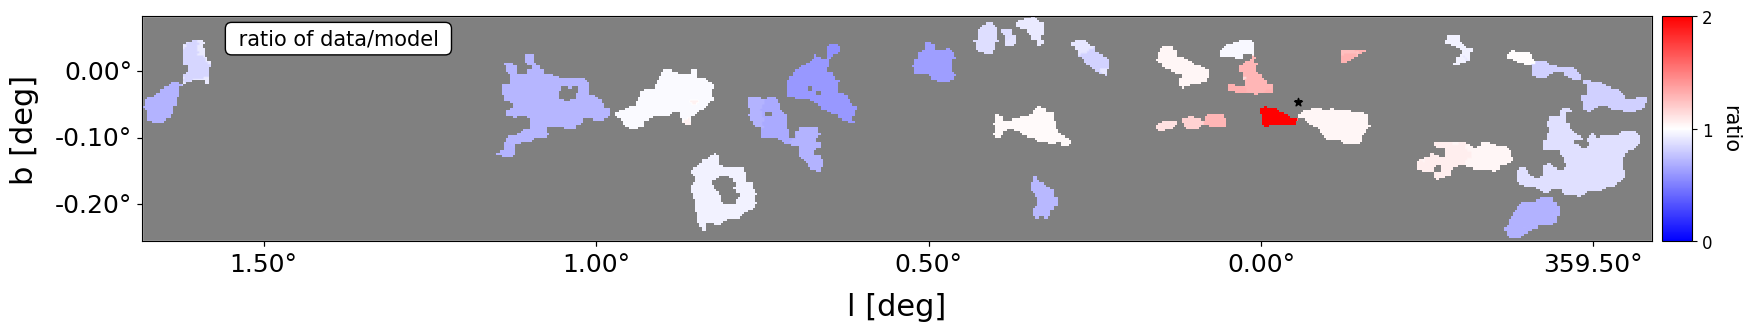

In [10]:
#count_ratio = (cloud_counts_full_mask)/(model_counts_full_mask)
count_ratio = counts_ratio_full_mask

cmap    = 'bwr'
#divnorm =mc.TwoSlopeNorm(vmin=np.min(count_ratio), vcenter=1, vmax=np.max(count_ratio))
divnorm =mc.TwoSlopeNorm(vmin=0, vcenter=1, vmax=2)

fig, ax = plt.subplots(nrows=1, subplot_kw={'projection': full_cloud_cat_mask_wcs}, figsize = (20,4), sharex=True, sharey=True)
ax.set_facecolor('gray')

ext_min = skycoord_to_pixel(SkyCoord(2, -0.3, unit="deg", frame='galactic'), star_counts_wcs)
ext_max = skycoord_to_pixel(SkyCoord(-1, 0.3, unit="deg", frame='galactic'), star_counts_wcs)
IM1 = ax.imshow(count_ratio,cmap=cmap,origin='lower', norm=divnorm)#extent=[ext_min[0],ext_max[0],ext_min[1],ext_max[1]])


lon = ax.coords[0]
lat = ax.coords[1]
lon.set_major_formatter('d.dd')
lat.set_major_formatter('d.dd')
lon.set_ticks_position('b')
lon.set_ticklabel_position('b')
lon.set_axislabel_position('b')
lat.set_ticks_position('l')
lat.set_ticklabel_position('l')
lat.set_axislabel_position('l')
ax.set_xlabel('l [deg]',fontsize=22)
ax.set_ylabel('b [deg]',fontsize=22)
#ax.set_xlim(ext_min[0],ext_max[0])
#ax.set_ylim(ext_min[1],ext_max[1])
ax.tick_params(labelsize=18) 
ax.text(0.13, 0.90, r' ratio of data/model ', ha='center', va='center', transform=ax.transAxes,
           bbox=dict(boxstyle = 'round', facecolor='white', edgecolor='k', alpha=1), fontsize=15)

#plot SgrA*
ax.scatter(-0.056, -0.046, marker = "*", s=35, color='k', transform=ax.get_transform('world'))

divider1 = make_axes_locatable(ax)
cax1 = divider1.append_axes("right", size="2%", pad=0.1,  axes_class=maxes.Axes)
cb1 = fig.colorbar(IM1, orientation="vertical", cax = cax1,ticks=[0., 1., 2]  )
cb1.set_label(label = r'ratio', labelpad=20, y=0.5, rotation=-90, fontsize = 15)
cb1.ax.tick_params(labelsize=12)



In [11]:
###create normalization for ratio
count_ratio_list = np.array(cloud_avg_count)/np.array(model_avg_count)

countratio_cn = 2. * ((1 - 0) / (2 - 0)) - 1.

countratio_normed = []

for i in range(len(count_ratio_list)):
    
    ### NORMING 
    z_countratio_i = 2. * ((count_ratio_list[i] - 0) / (2- 1) )- 1.
    countratio_normed.append(z_countratio_i-countratio_cn) 
    


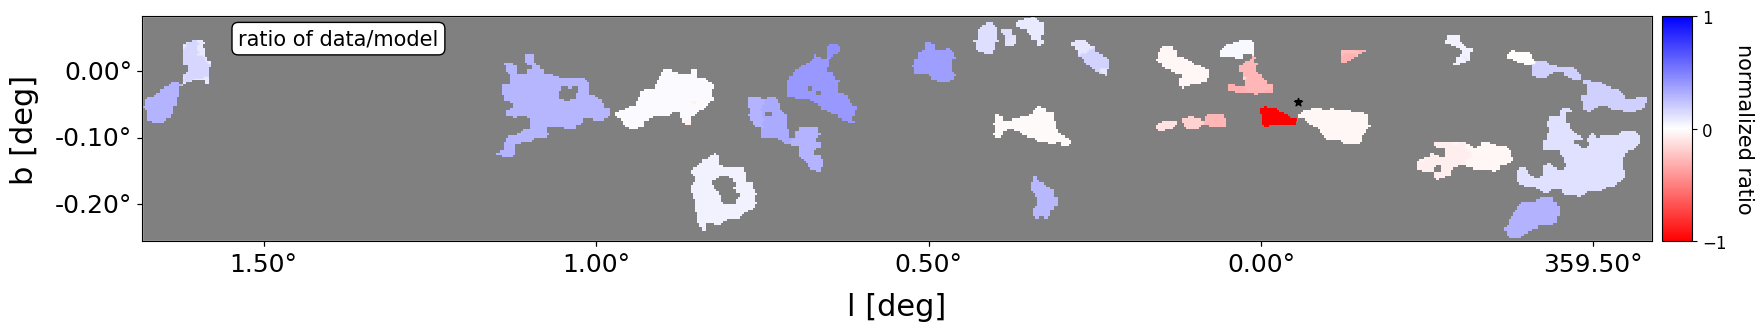

In [12]:
##plot the normed map
count_ratio_masked =  np.ma.masked_where(count_ratio.data==0, count_ratio)

countratio_map_normed = -(2. * ((count_ratio - 0) / (2 - 0)) - 1.)-countratio_cn



cmap    = 'bwr_r'
divnorm =mc.TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)

fig, ax = plt.subplots(nrows=1, subplot_kw={'projection': full_cloud_cat_mask_wcs}, figsize = (20,4), sharex=True, sharey=True)
ax.set_facecolor('gray')

IM1 = ax.imshow(countratio_map_normed,cmap=cmap,origin='lower', norm=divnorm)


lon = ax.coords[0]
lat = ax.coords[1]
lon.set_major_formatter('d.dd')
lat.set_major_formatter('d.dd')
lon.set_ticks_position('b')
lon.set_ticklabel_position('b')
lon.set_axislabel_position('b')
lat.set_ticks_position('l')
lat.set_ticklabel_position('l')
lat.set_axislabel_position('l')
ax.set_xlabel('l [deg]',fontsize=22)
ax.set_ylabel('b [deg]',fontsize=22)
#ax.set_xlim(ext_min[0],ext_max[0])
#ax.set_ylim(ext_min[1],ext_max[1])
ax.tick_params(labelsize=18) 
ax.text(0.13, 0.90, r'ratio of data/model', ha='center', va='center', transform=ax.transAxes,
           bbox=dict(boxstyle = 'round', facecolor='white', edgecolor='k', alpha=1), fontsize=15)

#plot SgrA*
ax.scatter(-0.056, -0.046, marker = "*", s=35, color='k', transform=ax.get_transform('world'))

divider1 = make_axes_locatable(ax)
cax1 = divider1.append_axes("right", size="2%", pad=0.1,  axes_class=maxes.Axes)
cb1 = fig.colorbar(IM1, orientation="vertical", cax = cax1,ticks=[-1., 0., 1]  )
cb1.set_label(label = r'normalized ratio', labelpad=20, y=0.5, rotation=-90, fontsize = 15)
cb1.ax.tick_params(labelsize=12)

plt.savefig('../paper_items/Figs/starcount_ratio_normed.pdf', bbox_inches='tight')


In [13]:
#import regridded model counts
model_counts_regrid_filename = './FITS/model_counts_conv36arcsec.fits'
model_counts_regrid = pyfits.open('./FITS/model_counts_conv36arcsec.fits')[0]                
model_counts_regrid_wcs = WCS(model_counts_regrid.header)

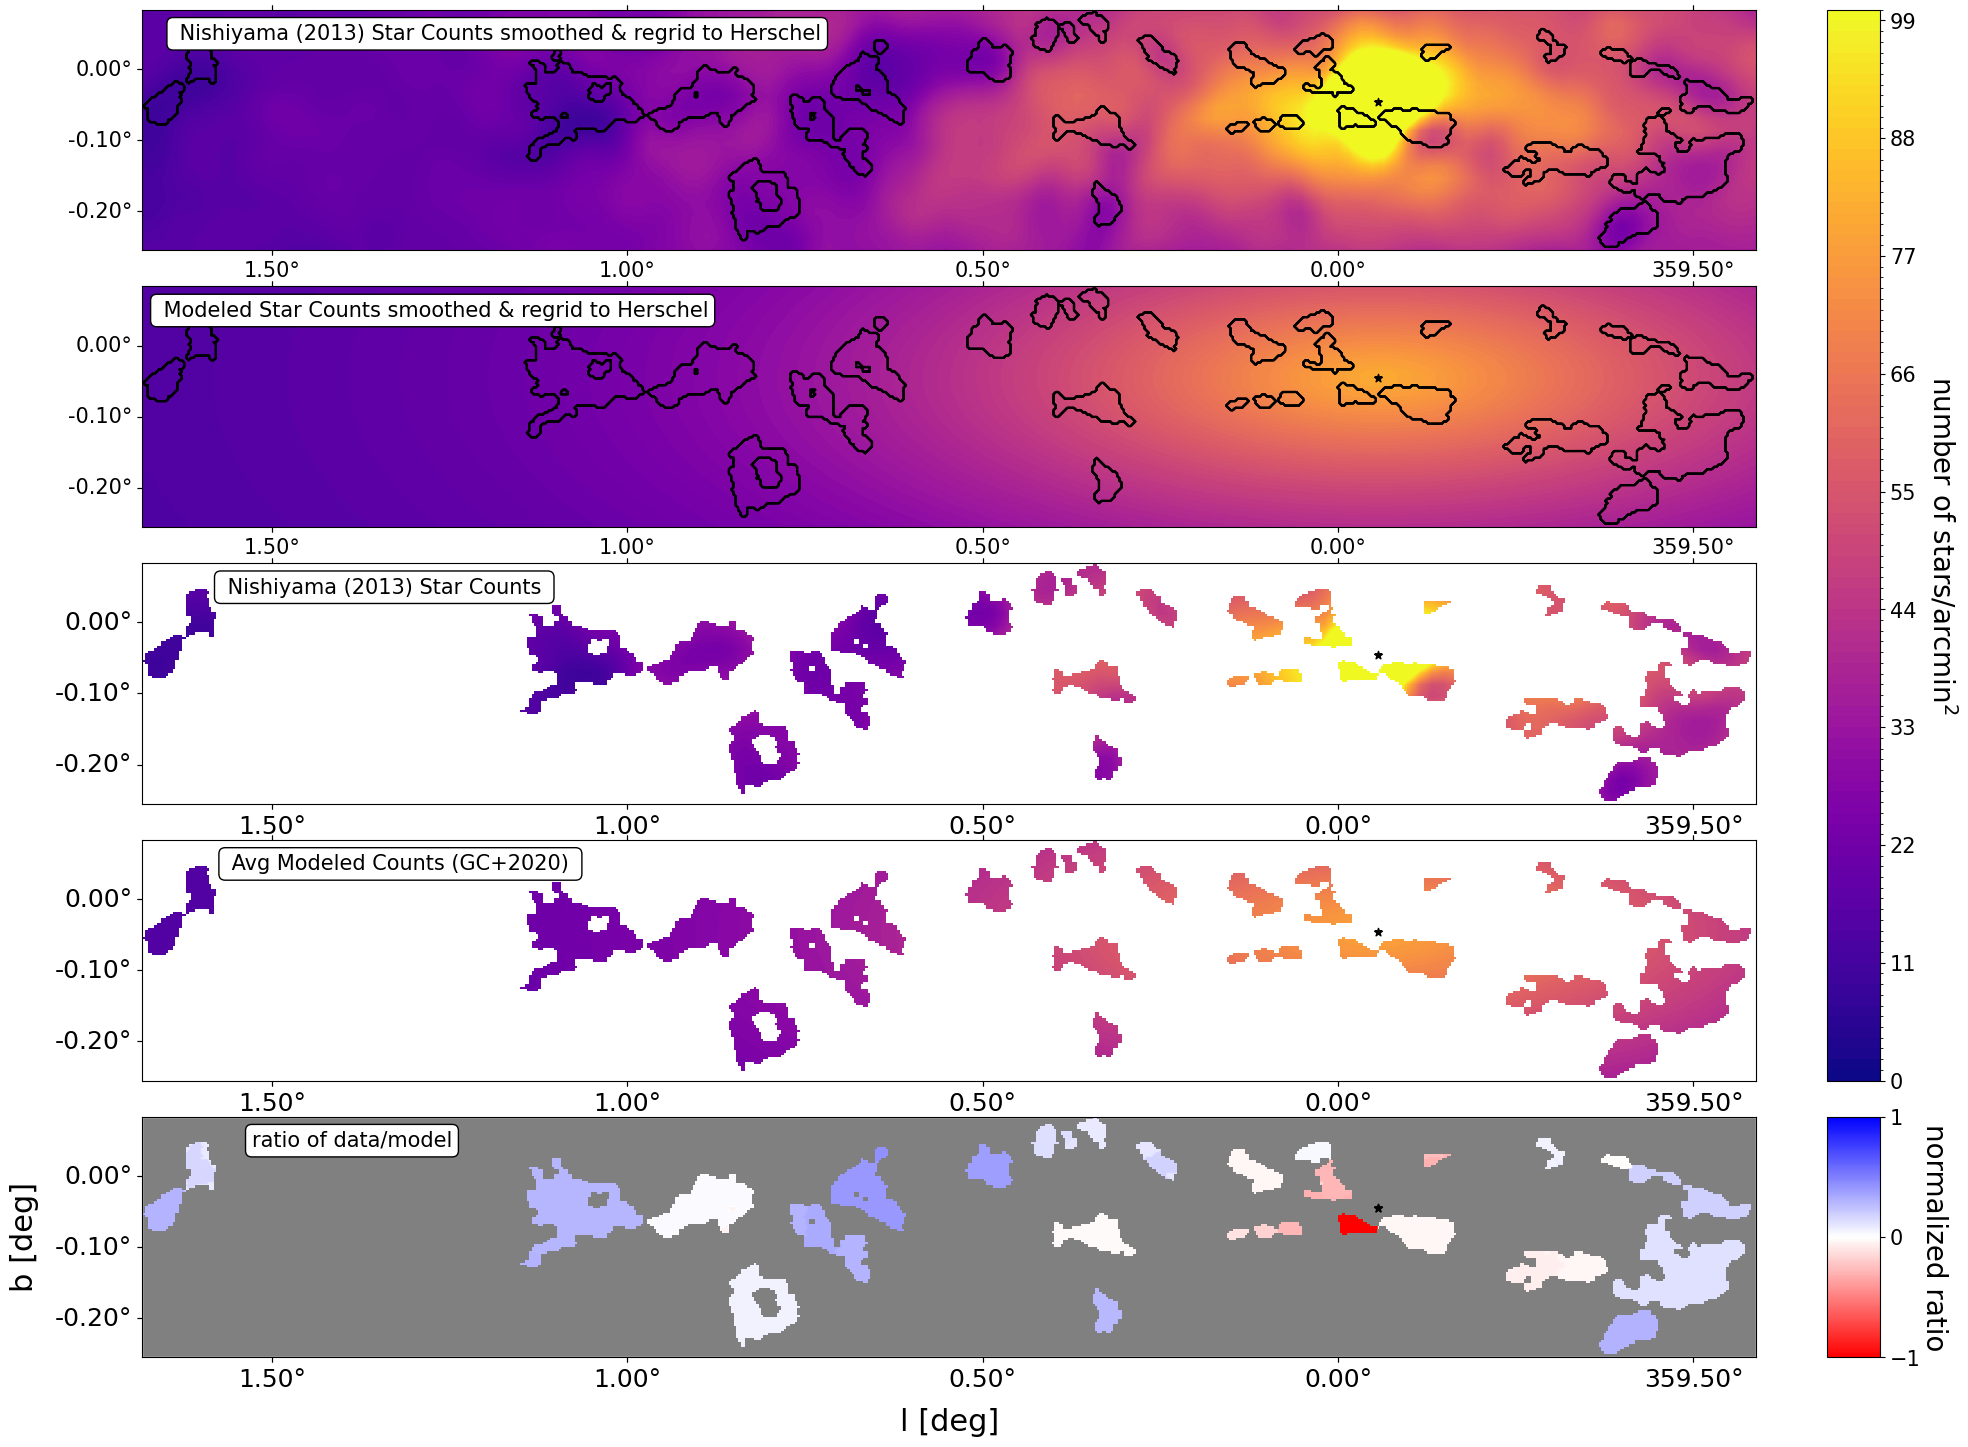

In [14]:
# Setup our Grid Speced plots
# Include an extra column between z and zoom for spacing
n_rows = 5
n_cols = 2

# 18 is more or less arbitrary,
# the ratio is important so that the imshow plots have 1:1 aspect ratio
width = 35
height_ratio = 0.5
fig = plt.figure(figsize=(width, width * height_ratio))
width_ratios = [2.0, 0.03]
height_ratios = [1.0, 1.0,1.0,1.0,1.0]
gs1 = fig.add_gridspec(
    n_rows, n_cols,
    width_ratios = width_ratios,
    height_ratios = height_ratios,
    wspace = -0.5,
    hspace = 0.15,
)
axes0 = fig.add_subplot(gs1[0, 0], projection= full_cloud_cat_mask_wcs)
axes1 = fig.add_subplot(gs1[1, 0], projection= full_cloud_cat_mask_wcs)
axes2 = fig.add_subplot(gs1[2, 0], projection= full_cloud_cat_mask_wcs)
axes3 = fig.add_subplot(gs1[3, 0], projection= full_cloud_cat_mask_wcs)
axes4 = fig.add_subplot(gs1[4, 0], projection= full_cloud_cat_mask_wcs)

count_colorbar_ax = fig.add_subplot(gs1[0:4, 1])
ratio_colorbar_ax = fig.add_subplot(gs1[4, 1])


levels  = np.linspace(0,100,101)
norm    = mc.BoundaryNorm(levels, 256)
cmap    = 'plasma'
#extent of plot
ext_min = skycoord_to_pixel(SkyCoord(1.67, -0.25, unit="deg", frame='galactic'), full_cloud_cat_mask_wcs)
ext_max = skycoord_to_pixel(SkyCoord(-0.6, 0.08, unit="deg", frame='galactic'), full_cloud_cat_mask_wcs)






IM0 = axes0.imshow(star_count_smooth_regrid,norm=norm,cmap=cmap,origin='lower') 
axes0.contour(full_cloud_cat_mask.data, levels=np.logspace(-4.7, -3., 10), colors='black', alpha=0.5)


lon = axes0.coords[0]
lat = axes0.coords[1]
lon.set_major_formatter('d.dd')
lat.set_major_formatter('d.dd')

axes0.set_xlabel(' ')
axes0.set_ylabel(' ')
#axes1.tick_params(axis='x', bottom=False, labelbottom=False)
lat.set_ticks_position('l')
lat.set_ticklabel_position('l')
lat.set_axislabel_position('l')
axes0.tick_params(labelsize=15) 
#axes0.set_xlim(ext_min[0],ext_max[0])
#axes0.set_ylim(ext_min[1],ext_max[1])
axes0.text(0.22, 0.90, r' Nishiyama (2013) Star Counts smoothed & regrid to Herschel', ha='center', va='center', transform=axes0.transAxes,
           bbox=dict(boxstyle = 'round', facecolor='white', edgecolor='k', alpha=1), fontsize=15)






IM1 = axes1.imshow(model_counts_regrid.data,norm=norm,cmap=cmap,origin='lower')
axes1.contour(full_cloud_cat_mask.data, levels=np.logspace(-4.7, -3., 10), colors='black', alpha=0.5)


lon = axes1.coords[0]
lat = axes1.coords[1]
lon.set_major_formatter('d.dd')
lat.set_major_formatter('d.dd')

axes1.set_xlabel(' ')
axes1.set_ylabel(' ')
#axes1.tick_params(axis='x', bottom=False, labelbottom=False)
lat.set_ticks_position('l')
lat.set_ticklabel_position('l')
lat.set_axislabel_position('l')
axes1.tick_params(labelsize=15) 
#axes1.set_xlim(ext_min[0],ext_max[0])
#axes1.set_ylim(ext_min[1],ext_max[1])
axes1.text(0.18, 0.90, r' Modeled Star Counts smoothed & regrid to Herschel', ha='center', va='center', transform=axes1.transAxes,
           bbox=dict(boxstyle = 'round', facecolor='white', edgecolor='k', alpha=1), fontsize=15)




IM2 = axes2.imshow(cloud_counts_full_mask,norm=norm,cmap=cmap,origin='lower')

lon = axes2.coords[0]
lat = axes2.coords[1]
lon.set_major_formatter('d.dd')
lat.set_major_formatter('d.dd')

axes2.set_xlabel(' ')
axes2.set_ylabel(' ')
#axes2.tick_params(axis='x', bottom=False, labelbottom=False)
lat.set_ticks_position('l')
lat.set_ticklabel_position('l')
lat.set_axislabel_position('l')
axes2.tick_params(labelsize=18) 
#axes2.set_xlim(ext_min[0],ext_max[0])
#axes2.set_ylim(ext_min[1],ext_max[1])
axes2.text(0.15, 0.90, r' Nishiyama (2013) Star Counts ', ha='center', va='center', transform=axes2.transAxes,
           bbox=dict(boxstyle = 'round', facecolor='white', edgecolor='k', alpha=1), fontsize=15)




IM3 = axes3.imshow(model_counts_full_mask,norm=norm,cmap=cmap,origin='lower')

lon = axes3.coords[0]
lat = axes3.coords[1]
axes3.set_xlabel(' ')
axes3.set_ylabel(' ')
#axes3.tick_params(axis='x', bottom=False, labelbottom=False)
lon.set_major_formatter('d.dd')
lat.set_major_formatter('d.dd')
lat.set_ticks_position('l')
lat.set_ticklabel_position('l')
lat.set_axislabel_position('l')
#axes3.set_xlim(ext_min[0],ext_max[0])
#axes3.set_ylim(ext_min[1],ext_max[1])
axes3.tick_params(labelsize=18) 
axes3.text(0.16, 0.90, r' Avg Modeled Counts (GC+2020) ', ha='center', va='center', transform=axes3.transAxes,
           bbox=dict(boxstyle = 'round', facecolor='white', edgecolor='k', alpha=1), fontsize=15)

#plot SgrA*
axes0.scatter(-0.056, -0.046, marker = "*", s=35, color='k', transform=axes0.get_transform('world'))
axes1.scatter(-0.056, -0.046, marker = "*", s=35, color='k', transform=axes1.get_transform('world'))
axes2.scatter(-0.056, -0.046, marker = "*", s=35, color='k', transform=axes2.get_transform('world'))
axes3.scatter(-0.056, -0.046, marker = "*", s=35, color='k', transform=axes3.get_transform('world'))
axes4.scatter(-0.056, -0.046, marker = "*", s=35, color='k', transform=axes4.get_transform('world'))


cb = fig.colorbar(
    mpl.cm.ScalarMappable(cmap=cmap, norm=norm),
    cax=count_colorbar_ax,
    spacing='proportional',
    orientation='vertical',

)
cb.ax.tick_params(labelsize=15)  # set your label size here
cb.set_label(r'number of stars/arcmin$^{2}$', labelpad=30, y=0.5,fontsize=20,rotation=-90)



cmap_normed    = 'bwr_r'
divnorm_normed =mc.TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)

axes4.set_facecolor('gray')

IM4 = axes4.imshow(countratio_map_normed,cmap=cmap_normed,origin='lower', norm=divnorm_normed)


lon = axes4.coords[0]
lat = axes4.coords[1]
lon.set_major_formatter('d.dd')
lat.set_major_formatter('d.dd')
lon.set_ticks_position('b')
lon.set_ticklabel_position('b')
lon.set_axislabel_position('b')
lat.set_ticks_position('l')
lat.set_ticklabel_position('l')
lat.set_axislabel_position('l')
axes4.set_xlabel('l [deg]',fontsize=22)
axes4.set_ylabel('b [deg]',fontsize=22)
#axes4.set_xlim(ext_min[0],ext_max[0])
#axes4.set_ylim(ext_min[1],ext_max[1])
axes4.tick_params(labelsize=18) 
axes4.text(0.13, 0.90, r'ratio of data/model', ha='center', va='center', transform=axes4.transAxes,
           bbox=dict(boxstyle = 'round', facecolor='white', edgecolor='k', alpha=1), fontsize=15)

#plot SgrA*
axes4.scatter(-0.056, -0.046, marker = "*", s=35, color='k', transform=axes4.get_transform('world'))

cb4 = fig.colorbar(IM4, orientation="vertical", cax = ratio_colorbar_ax,ticks=[-1., 0., 1]  )
cb4.set_label(label = r'normalized ratio', labelpad=20, y=0.5, rotation=-90, fontsize = 20)
cb4.ax.tick_params(labelsize=15)

plt.savefig('../paper_items/Figs/5_panel_StarCountMethod.pdf', bbox_inches='tight')


# What if we masked out the SgrA* clouds?

In [15]:
# circle center
cen_x, cen_y = skycoord_to_pixel(SkyCoord(-0.056, -0.046, unit="deg", frame='galactic'), full_cloud_cat_mask_wcs)

gc_distance = 8.2 * u.kpc
gc_length = 20 * u.pc
rad_deg = (gc_length / gc_distance).to(u.deg, equivalencies=u.dimensionless_angles())

pixelscale = u.pixel_scale(model_counts_regrid.header['CDELT2']*u.deg/u.pixel)
rad_pix = (rad_deg).to(u.pixel, pixelscale)  

# Get image parameters
a = full_cloud_cat_mask.shape[0]
b = full_cloud_cat_mask.shape[1]

# Find radial distances
[X, Y] = np.meshgrid(np.arange(b) - cen_x, np.arange(a) - cen_y)
R = np.sqrt(np.square(X) + np.square(Y))

mosaic_circ_vals = full_cloud_cat_mask.data[R<=rad_pix.value]
mosaic_circ_index = np.where(R<=rad_pix.value)

In [16]:
# ellipse center
cen_x, cen_y = skycoord_to_pixel(SkyCoord(-0.056, -0.046, unit="deg", frame='galactic'), full_cloud_cat_mask_wcs)

gc_distance = 8.2 * u.kpc
a_deg = (25 * u.pc / gc_distance).to(u.deg, equivalencies=u.dimensionless_angles())
b_deg = (15 * u.pc / gc_distance).to(u.deg, equivalencies=u.dimensionless_angles())

pixelscale = u.pixel_scale(model_counts_regrid.header['CDELT2']*u.deg/u.pixel)
a_pix = (a_deg).to(u.pixel, pixelscale)  
b_pix = (b_deg).to(u.pixel, pixelscale)  


# Get image parameters
a = full_cloud_cat_mask.shape[0]
b = full_cloud_cat_mask.shape[1]

# Find radial distances
def checkpoint(cen_x, cen_y, x, y, a, b):
 
    # checking the equation of
    # ellipse with the given point
    p = (((x - cen_x)**2) / a**2) + (((y - cen_y)**2) / (b**2))
 
    return p


[X, Y] = np.meshgrid(np.arange(b), np.arange(a))
R_ell = checkpoint(cen_x, cen_y, X,Y, a_pix.value, b_pix.value)

mosaic_ell_vals = full_cloud_cat_mask.data[R_ell<=1]
mosaic_ell_index = np.where(R_ell<=1)

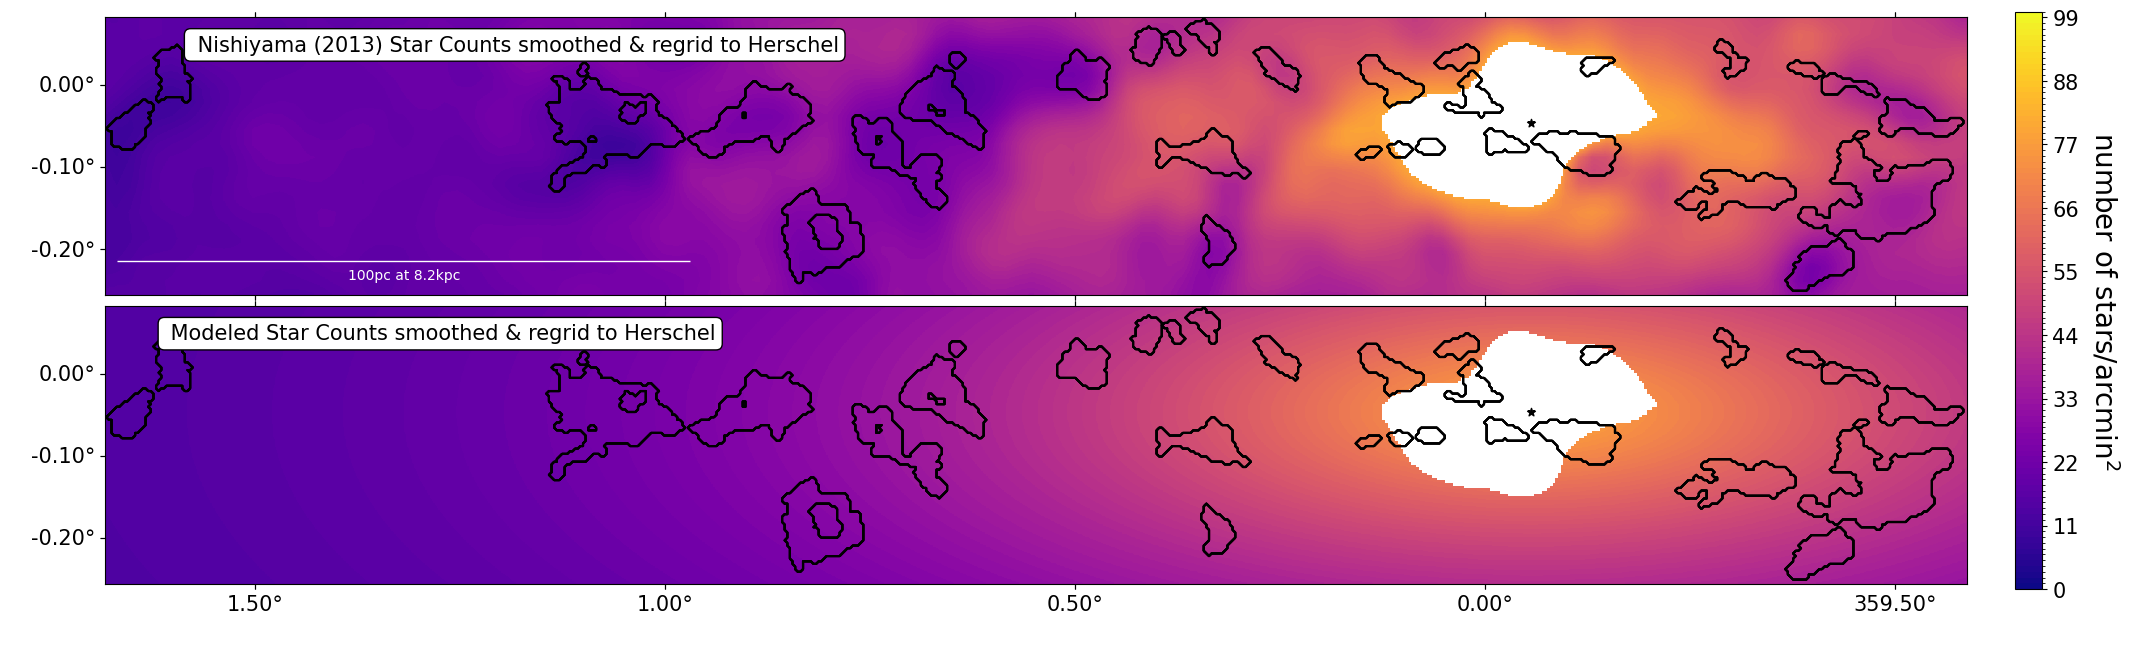

In [22]:
# Setup our Grid Speced plots
# Include an extra column between z and zoom for spacing
n_rows = 2
n_cols = 2

# 18 is more or less arbitrary,
# the ratio is important so that the imshow plots have 1:1 aspect ratio
width = 25
height_ratio = 0.3
fig = plt.figure(figsize=(width, width * height_ratio))
width_ratios = [2.0, 0.03]
height_ratios = [1.0, 1.0]
gs1 = fig.add_gridspec(
    n_rows, n_cols,
    width_ratios = width_ratios,
    height_ratios = height_ratios,
    wspace = 0.05,
    hspace = 0.0,
)
axes0 = fig.add_subplot(gs1[0, 0], projection= full_cloud_cat_mask_wcs)
axes1 = fig.add_subplot(gs1[1, 0], projection= full_cloud_cat_mask_wcs)

count_colorbar_ax = fig.add_subplot(gs1[0:2, 1])

levels  = np.linspace(0,100,101)
norm    = mc.BoundaryNorm(levels, 256)
cmap    = 'plasma'
#extent of plot
ext_min = skycoord_to_pixel(SkyCoord(1.67, -0.25, unit="deg", frame='galactic'), full_cloud_cat_mask_wcs)
ext_max = skycoord_to_pixel(SkyCoord(-0.6, 0.08, unit="deg", frame='galactic'), full_cloud_cat_mask_wcs)




badfit_mask = np.where(star_count_smooth_regrid > 1*np.max(model_counts_regrid.data))
star_count_smooth_regrid_maskedcent = np.copy(star_count_smooth_regrid)
model_counts_regrid_maskedcent = np.copy(model_counts_regrid.data)

star_count_smooth_regrid_maskedcent[badfit_mask] = np.nan
model_counts_regrid_maskedcent[badfit_mask] = np.nan



IM0 = axes0.imshow(star_count_smooth_regrid_maskedcent,norm=norm,cmap=cmap,origin='lower') 
axes0.contour(full_cloud_cat_mask.data, levels=np.logspace(-4.7, -3., 10), colors='black', alpha=0.5)

#add scale bar
gc_distance = 8.2 * u.kpc
scalebar_length = 100 * u.pc
scalebar_angle_100pc = (scalebar_length / gc_distance).to(u.deg, equivalencies=u.dimensionless_angles())
add_scalebar(axes0, scalebar_angle_100pc, label='100pc at 8.2kpc',color='white',corner='bottom left')


lon = axes0.coords[0]
lat = axes0.coords[1]
lon.set_major_formatter('d.dd')
lat.set_major_formatter('d.dd')

axes0.set_xlabel(' ')
axes0.set_ylabel(' ')
#axes1.tick_params(axis='x', bottom=False, labelbottom=False)
lat.set_ticks_position('l')
lat.set_ticklabel_position('l')
lat.set_axislabel_position('l')
axes0.tick_params(labelsize=15) 
#axes0.set_xlim(ext_min[0],ext_max[0])
#axes0.set_ylim(ext_min[1],ext_max[1])
axes0.text(0.22, 0.90, r' Nishiyama (2013) Star Counts smoothed & regrid to Herschel', ha='center', va='center', transform=axes0.transAxes,
           bbox=dict(boxstyle = 'round', facecolor='white', edgecolor='k', alpha=1), fontsize=15)






IM1 = axes1.imshow(model_counts_regrid_maskedcent,norm=norm,cmap=cmap,origin='lower')
axes1.contour(full_cloud_cat_mask.data, levels=np.logspace(-4.7, -3., 10), colors='black', alpha=0.5)


lon = axes1.coords[0]
lat = axes1.coords[1]
lon.set_major_formatter('d.dd')
lat.set_major_formatter('d.dd')

axes1.set_xlabel(' ')
axes1.set_ylabel(' ')
#axes1.tick_params(axis='x', bottom=False, labelbottom=False)
lat.set_ticks_position('l')
lat.set_ticklabel_position('l')
lat.set_axislabel_position('l')
axes1.tick_params(labelsize=15) 
#axes1.set_xlim(ext_min[0],ext_max[0])
#axes1.set_ylim(ext_min[1],ext_max[1])
axes1.text(0.18, 0.90, r' Modeled Star Counts smoothed & regrid to Herschel', ha='center', va='center', transform=axes1.transAxes,
           bbox=dict(boxstyle = 'round', facecolor='white', edgecolor='k', alpha=1), fontsize=15)


#plot SgrA*
axes0.scatter(-0.056, -0.046, marker = "*", s=35, color='k', transform=axes0.get_transform('world'))
axes1.scatter(-0.056, -0.046, marker = "*", s=35, color='k', transform=axes1.get_transform('world'))


cb = fig.colorbar(
    mpl.cm.ScalarMappable(cmap=cmap, norm=norm),
    cax=count_colorbar_ax,
    spacing='proportional',
    orientation='vertical',

)
cb.ax.tick_params(labelsize=15)  # set your label size here
cb.set_label(r'number of stars/arcmin$^{2}$', labelpad=30, y=0.5,fontsize=20,rotation=-90)



cmap_normed    = 'bwr_r'
divnorm_normed =mc.TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)




In [34]:
np.shape(mask_regrid)
#np.shape(badfit_mask)

(106, 711)

In [41]:


## import the individual cloud masks and take cutouts
# find the average star count in both the nishiyama regrid and the model regrid 
  
    
cloud_counts_full_mask = np.zeros(np.shape(full_cloud_cat_mask.data)) 
model_counts_full_mask = np.zeros(np.shape(full_cloud_cat_mask.data)) 
counts_ratio_full_mask = np.zeros(np.shape(full_cloud_cat_mask.data)) 

counts_tab = Table()
cloud_index = []
cloud_name  = []
cloud_avg_count = []
model_avg_count = []
cloud_min_count = []
model_min_count = []
cloud_stddv = []
model_stddv = []
cloud_totalnum =[]
model_totalnum =[]
cloud_count_ratio = []
cloud_count_stddv = []

for i in range(len(mask_files)):


    if cat_index[i]=='16a':
        cloud_index.append(cat_index[i])
        cloud_name.append(cloud_list[i])
        cloud_avg_count.append(np.nan)
        model_avg_count.append(np.nan)
        cloud_min_count.append(np.nan)
        model_min_count.append(np.nan)
        cloud_stddv.append(np.nan)
        model_stddv.append(np.nan)
        cloud_totalnum.append(np.nan)
        model_totalnum.append(np.nan)
        cloud_count_ratio.append(np.nan)
        cloud_count_stddv.append(np.nan)
        continue
            
    hdu_file = pyfits.open(mask_files[i])[0]                
    hdu_wcs = WCS(hdu_file.header)

    
    #regrid to match the map
    mask_regrid, regrid_footprint = reproject_interp(hdu_file, full_cloud_cat_mask.header)
    mask_regrid.astype(int)
    mask_regrid[mask_regrid>0] = 1
    mask_regrid[np.isnan(mask_regrid)==True] = 0

    
    cloud_counts_masked =  np.ma.masked_where(mask_regrid==0, star_count_smooth_regrid)
    model_counts_masked =  np.ma.masked_where(mask_regrid==0, model_count_smoothed_regrid)
    cloud_ratio_masked  =  np.ma.masked_where(mask_regrid==0, star_count_smooth_regrid)
    
    cloud_counts_masked.data[cloud_counts_masked.mask==True] = 0
    model_counts_masked.data[model_counts_masked.mask==True] = 0
    cloud_ratio_masked.data[cloud_ratio_masked.mask==True] = 0
    
    
    cloud_badfit_mask = np.where(cloud_counts_masked.data > 1*np.max(model_count_smoothed_regrid))[0]

    
    cloud_count_ratio_map = cloud_counts_masked/model_counts_masked
    
    #If the cloud falls within the masked ellipse (i.e. where the model sucks)
    #mask that cloud out completely from the table and move on
    #check_mask = checkpoint(cen_x, cen_y, np.where(cloud_count_ratio_map.data>0)[1],np.where(cloud_count_ratio_map.data>0)[0], a_pix.value, b_pix.value)

    if len(cloud_badfit_mask) > 0.3*len(np.where(mask_regrid>0)[0]):
        cloud_index.append(cat_index[i])
        cloud_name.append(cloud_list[i])
        cloud_avg_count.append(np.nan)
        model_avg_count.append(np.nan)
        cloud_min_count.append(np.nan)
        model_min_count.append(np.nan)
        cloud_stddv.append(np.nan)
        model_stddv.append(np.nan)
        cloud_totalnum.append(np.nan)
        model_totalnum.append(np.nan)
        cloud_count_ratio.append(np.nan)
        cloud_count_stddv.append(np.nan)
        continue

    else:
        cloud_count_ratio.append(np.nanmedian(cloud_count_ratio_map.data[cloud_count_ratio_map.data>0]))
        cloud_count_stddv.append(np.std(cloud_count_ratio_map.data[cloud_count_ratio_map.data>0]))

        cloud_index.append(cat_index[i])
        cloud_name.append(cloud_list[i])
        cloud_avg_count.append(np.nanmedian(cloud_counts_masked.data[np.where(cloud_counts_masked.data>0)]))
        model_avg_count.append(np.nanmedian(model_counts_masked.data[np.where(model_counts_masked.data>0)]))
        cloud_min_count.append(np.nanmin(cloud_counts_masked))
        model_min_count.append(np.nanmin(model_counts_masked))


        #cloud_counts_masked[cloud_counts_masked>0] = np.nanmedian(cloud_counts_masked.data[np.where(cloud_counts_masked.data>0)])
        #model_counts_masked[model_counts_masked>0] = np.nanmedian(model_counts_masked.data[np.where(model_counts_masked.data>0)])
        cloud_ratio_masked[cloud_ratio_masked>0] = np.nanmedian(cloud_count_ratio_map.data[cloud_count_ratio_map.data>0])

        #remove overlapping artifacts from regridding 
        cloud_counts_masked[np.where(cloud_counts_full_mask>0)] = 0
        model_counts_masked[np.where(model_counts_full_mask>0)] = 0
        cloud_ratio_masked[np.where(counts_ratio_full_mask>0)] = 0

        cloud_counts_full_mask+= cloud_counts_masked
        model_counts_full_mask+= model_counts_masked
        counts_ratio_full_mask+= cloud_ratio_masked 
    

cloud_counts_full_mask =  np.ma.masked_where(cloud_counts_full_mask==0, cloud_counts_full_mask)
model_counts_full_mask =  np.ma.masked_where(model_counts_full_mask==0, model_counts_full_mask)
counts_ratio_full_mask =  np.ma.masked_where(counts_ratio_full_mask==0, counts_ratio_full_mask)



counts_tab['cloud_index'] = cloud_index
counts_tab['cloud_name'] = cloud_name
counts_tab['cloud_avg_count'] = cloud_avg_count
counts_tab['model_avg_count'] = model_avg_count
counts_tab['cloud_min_count'] = cloud_min_count
counts_tab['model_min_count'] = model_min_count
counts_tab['counts_ratio_from_avg'] = cloud_count_ratio
counts_tab['counts_ratio_stdv'] = cloud_count_stddv #np.sqrt((np.array(cloud_stddv)/np.array(cloud_avg_count))**2 + (np.array(model_stddv)/np.array(model_avg_count))**2) 


counts_tab.write("/Users/danilipman/Documents/Research/UConn/CMZ_SYNTH/starcounts_tab.tex", overwrite=True)


/var/folders/4b/_cshhy012yj8k_187jxt881r0000gn/T/ipykernel_34327/231327328.py:47: RuntimeWarning: invalid value encountered in cast
  mask_regrid.astype(int)


In [42]:
counts_tab

cloud_index,cloud_name,cloud_avg_count,model_avg_count,cloud_min_count,model_min_count,counts_ratio_from_avg,counts_ratio_stdv
str3,str14,float64,float64,float64,float64,float64,float64
1,G359.475-0.044,40.144448514869204,49.654241825070116,35.97716789366406,46.18774098945748,0.8130800685330066,0.085614017028984
2,G359.508-0.135,40.87073208555847,47.10699762417615,35.044997436928455,41.70694042245204,0.8797177407572463,0.06832619292405771
3,G359.561-0.001,43.87142782820179,53.41807454286464,38.705760035001326,51.24813402264428,0.816134888085499,0.06167426502330663
4a,G359.595-0.223,28.791242056680474,41.207286282480815,23.328808414590284,37.71057143690689,0.7001177511768318,0.06901279570397634
4b,G359.595-0.223,28.177290455631294,40.417538189823794,23.328808414590284,37.71057143690689,0.7033710395037018,0.0769975611441995
5,G359.608+0.018,55.82924029394473,54.87771319409692,50.960434772543884,53.32961775786007,1.0112379315536946,0.03328843870703938
6a,G359.688-0.132,57.64956562422388,55.554509402396086,51.23114281630295,52.166913707875416,1.0389205391383807,0.0406530886769881
6b,G359.688-0.132,61.206801188977515,57.994769112132644,55.579594839572366,53.73551860887338,1.0667309088181687,0.032793335772444525
7a,G359.701+0.032,55.556315021612136,58.19416911908509,54.03325082046088,55.54394780619246,0.9495721450148745,0.03722769025246197


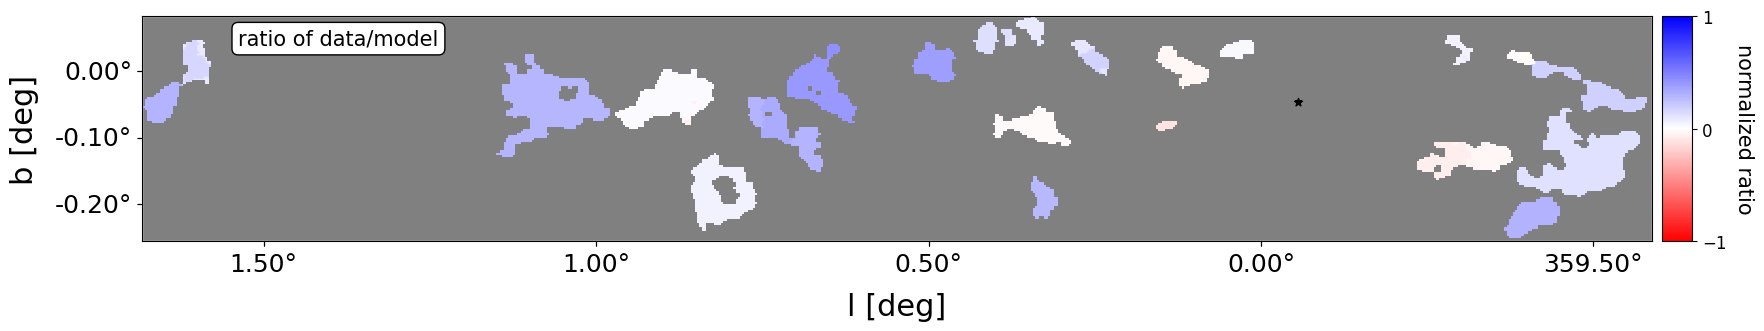

In [43]:
##plot the normed map
count_ratio = counts_ratio_full_mask
count_ratio_masked =  np.ma.masked_where(count_ratio.data==0, count_ratio)

countratio_map_normed = -(2. * ((count_ratio - 0) / (2 - 0)) - 1.)-countratio_cn



cmap    = 'bwr_r'
divnorm =mc.TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)

fig, ax = plt.subplots(nrows=1, subplot_kw={'projection': full_cloud_cat_mask_wcs}, figsize = (20,4), sharex=True, sharey=True)
ax.set_facecolor('gray')

IM1 = ax.imshow(countratio_map_normed,cmap=cmap,origin='lower', norm=divnorm)


lon = ax.coords[0]
lat = ax.coords[1]
lon.set_major_formatter('d.dd')
lat.set_major_formatter('d.dd')
lon.set_ticks_position('b')
lon.set_ticklabel_position('b')
lon.set_axislabel_position('b')
lat.set_ticks_position('l')
lat.set_ticklabel_position('l')
lat.set_axislabel_position('l')
ax.set_xlabel('l [deg]',fontsize=22)
ax.set_ylabel('b [deg]',fontsize=22)
#ax.set_xlim(ext_min[0],ext_max[0])
#ax.set_ylim(ext_min[1],ext_max[1])
ax.tick_params(labelsize=18) 
ax.text(0.13, 0.90, r'ratio of data/model', ha='center', va='center', transform=ax.transAxes,
           bbox=dict(boxstyle = 'round', facecolor='white', edgecolor='k', alpha=1), fontsize=15)

#plot SgrA*
ax.scatter(-0.056, -0.046, marker = "*", s=35, color='k', transform=ax.get_transform('world'))

divider1 = make_axes_locatable(ax)
cax1 = divider1.append_axes("right", size="2%", pad=0.1,  axes_class=maxes.Axes)
cb1 = fig.colorbar(IM1, orientation="vertical", cax = cax1,ticks=[-1., 0., 1]  )
cb1.set_label(label = r'normalized ratio', labelpad=20, y=0.5, rotation=-90, fontsize = 15)
cb1.ax.tick_params(labelsize=12)

plt.savefig('../paper_items/Figs/starcount_ratio_normed.pdf', bbox_inches='tight')


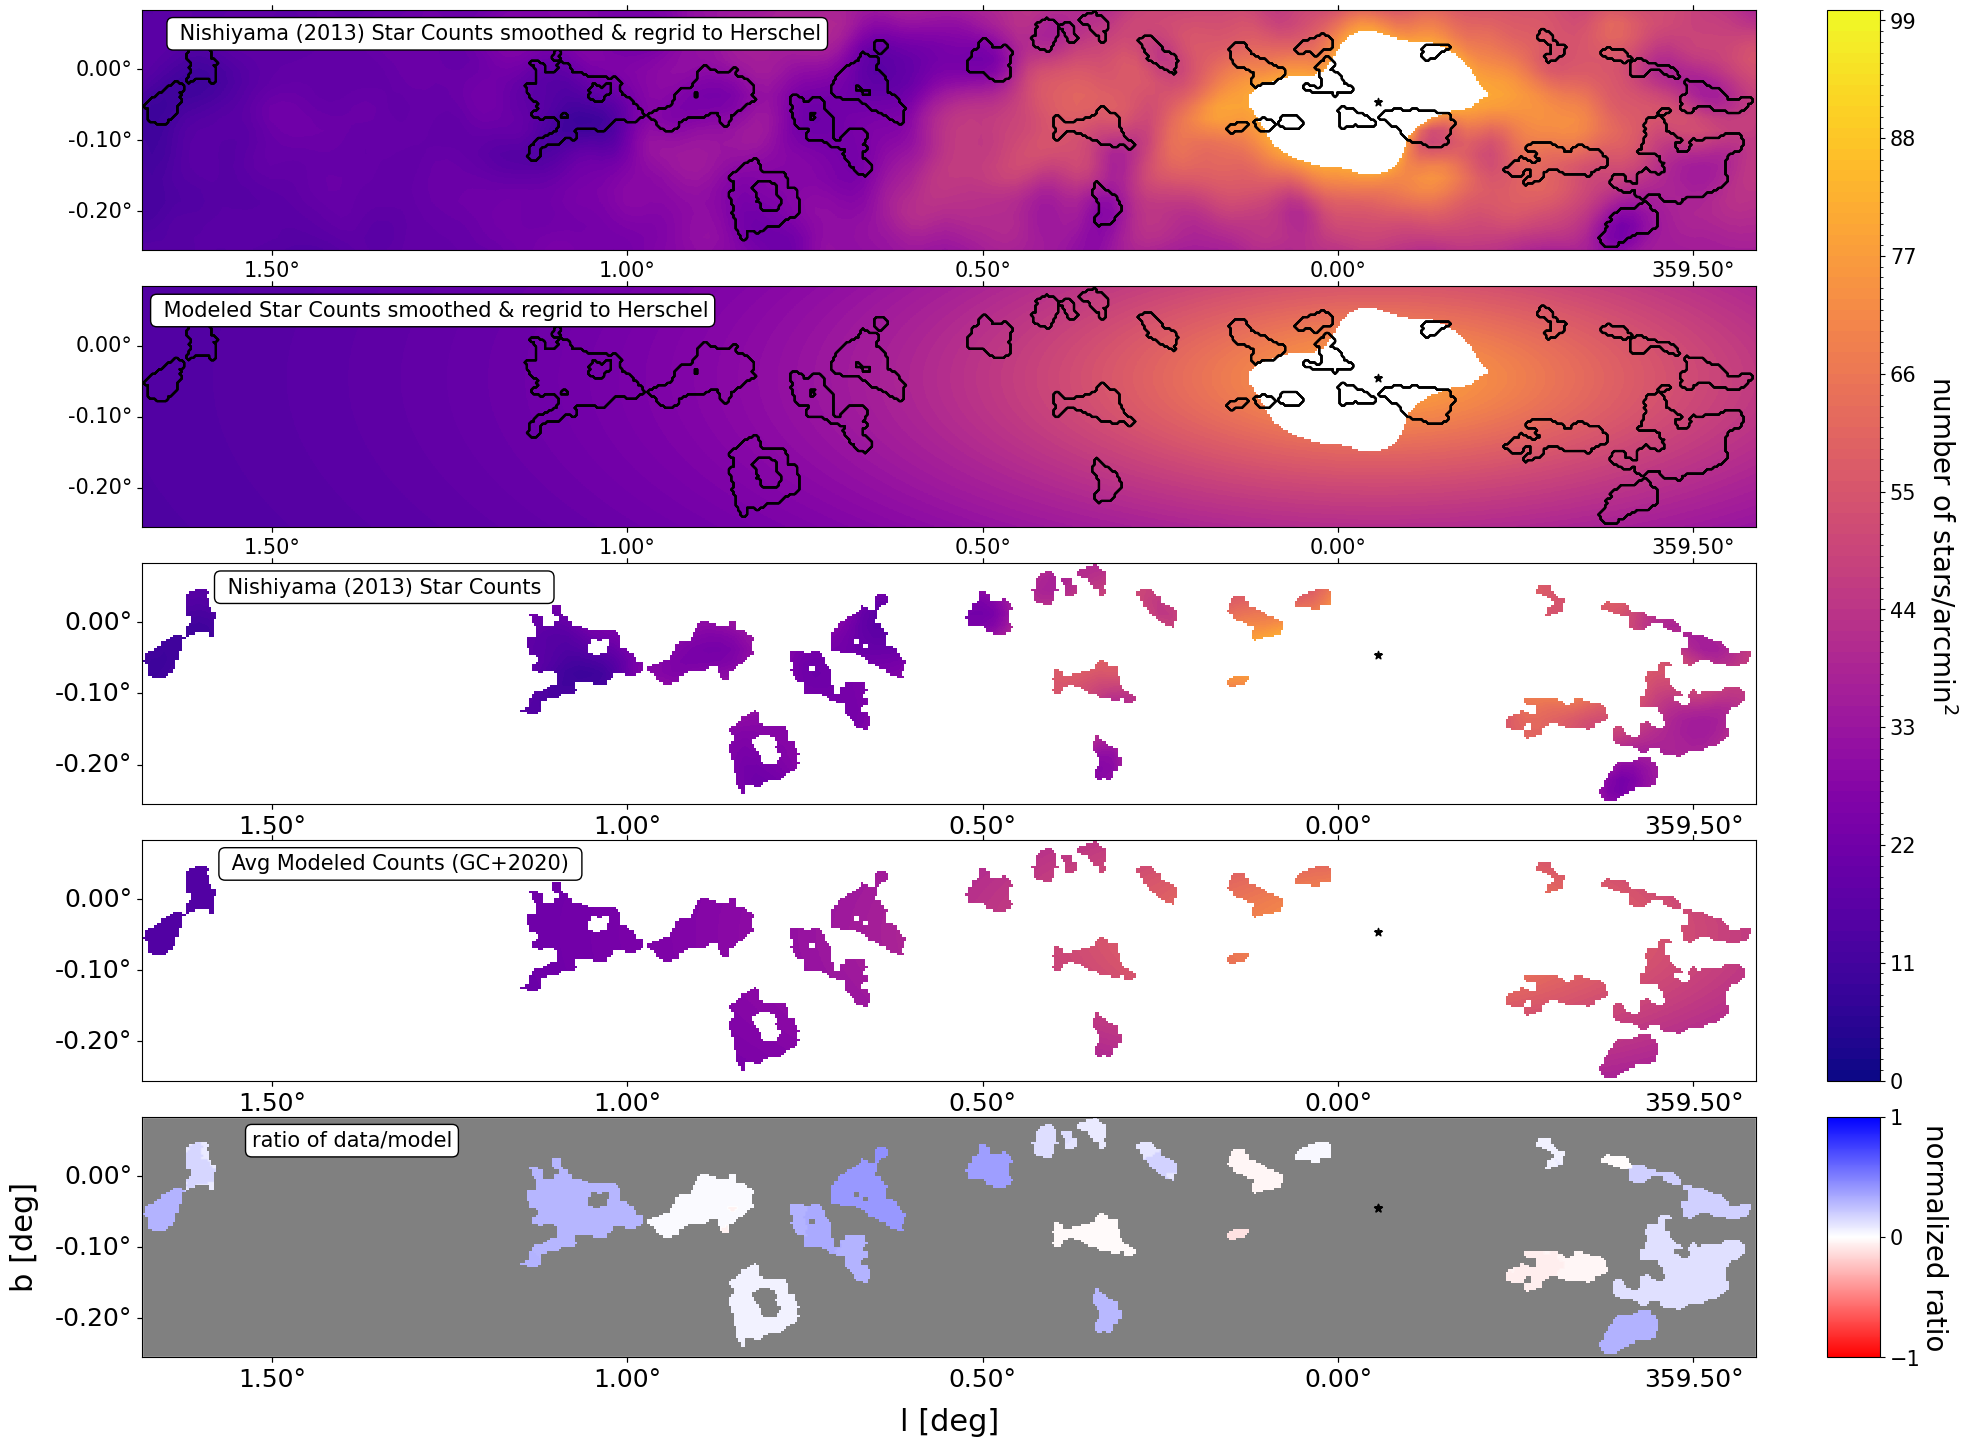

In [44]:
# Setup our Grid Speced plots
# Include an extra column between z and zoom for spacing
n_rows = 5
n_cols = 2

# 18 is more or less arbitrary,
# the ratio is important so that the imshow plots have 1:1 aspect ratio
width = 35
height_ratio = 0.5
fig = plt.figure(figsize=(width, width * height_ratio))
width_ratios = [2.0, 0.03]
height_ratios = [1.0, 1.0,1.0,1.0,1.0]
gs1 = fig.add_gridspec(
    n_rows, n_cols,
    width_ratios = width_ratios,
    height_ratios = height_ratios,
    wspace = -0.5,
    hspace = 0.15,
)
axes0 = fig.add_subplot(gs1[0, 0], projection= full_cloud_cat_mask_wcs)
axes1 = fig.add_subplot(gs1[1, 0], projection= full_cloud_cat_mask_wcs)
axes2 = fig.add_subplot(gs1[2, 0], projection= full_cloud_cat_mask_wcs)
axes3 = fig.add_subplot(gs1[3, 0], projection= full_cloud_cat_mask_wcs)
axes4 = fig.add_subplot(gs1[4, 0], projection= full_cloud_cat_mask_wcs)

count_colorbar_ax = fig.add_subplot(gs1[0:4, 1])
ratio_colorbar_ax = fig.add_subplot(gs1[4, 1])


levels  = np.linspace(0,100,101)
norm    = mc.BoundaryNorm(levels, 256)
cmap    = 'plasma'
#extent of plot
ext_min = skycoord_to_pixel(SkyCoord(1.67, -0.25, unit="deg", frame='galactic'), full_cloud_cat_mask_wcs)
ext_max = skycoord_to_pixel(SkyCoord(-0.6, 0.08, unit="deg", frame='galactic'), full_cloud_cat_mask_wcs)






IM0 = axes0.imshow(star_count_smooth_regrid_maskedcent,norm=norm,cmap=cmap,origin='lower') 
axes0.contour(full_cloud_cat_mask.data, levels=np.logspace(-4.7, -3., 10), colors='black', alpha=0.5)


lon = axes0.coords[0]
lat = axes0.coords[1]
lon.set_major_formatter('d.dd')
lat.set_major_formatter('d.dd')

axes0.set_xlabel(' ')
axes0.set_ylabel(' ')
#axes1.tick_params(axis='x', bottom=False, labelbottom=False)
lat.set_ticks_position('l')
lat.set_ticklabel_position('l')
lat.set_axislabel_position('l')
axes0.tick_params(labelsize=15) 
#axes0.set_xlim(ext_min[0],ext_max[0])
#axes0.set_ylim(ext_min[1],ext_max[1])
axes0.text(0.22, 0.90, r' Nishiyama (2013) Star Counts smoothed & regrid to Herschel', ha='center', va='center', transform=axes0.transAxes,
           bbox=dict(boxstyle = 'round', facecolor='white', edgecolor='k', alpha=1), fontsize=15)






IM1 = axes1.imshow(model_counts_regrid_maskedcent,norm=norm,cmap=cmap,origin='lower')
axes1.contour(full_cloud_cat_mask.data, levels=np.logspace(-4.7, -3., 10), colors='black', alpha=0.5)


lon = axes1.coords[0]
lat = axes1.coords[1]
lon.set_major_formatter('d.dd')
lat.set_major_formatter('d.dd')

axes1.set_xlabel(' ')
axes1.set_ylabel(' ')
#axes1.tick_params(axis='x', bottom=False, labelbottom=False)
lat.set_ticks_position('l')
lat.set_ticklabel_position('l')
lat.set_axislabel_position('l')
axes1.tick_params(labelsize=15) 
#axes1.set_xlim(ext_min[0],ext_max[0])
#axes1.set_ylim(ext_min[1],ext_max[1])
axes1.text(0.18, 0.90, r' Modeled Star Counts smoothed & regrid to Herschel', ha='center', va='center', transform=axes1.transAxes,
           bbox=dict(boxstyle = 'round', facecolor='white', edgecolor='k', alpha=1), fontsize=15)




IM2 = axes2.imshow(cloud_counts_full_mask,norm=norm,cmap=cmap,origin='lower')

lon = axes2.coords[0]
lat = axes2.coords[1]
lon.set_major_formatter('d.dd')
lat.set_major_formatter('d.dd')

axes2.set_xlabel(' ')
axes2.set_ylabel(' ')
#axes2.tick_params(axis='x', bottom=False, labelbottom=False)
lat.set_ticks_position('l')
lat.set_ticklabel_position('l')
lat.set_axislabel_position('l')
axes2.tick_params(labelsize=18) 
#axes2.set_xlim(ext_min[0],ext_max[0])
#axes2.set_ylim(ext_min[1],ext_max[1])
axes2.text(0.15, 0.90, r' Nishiyama (2013) Star Counts ', ha='center', va='center', transform=axes2.transAxes,
           bbox=dict(boxstyle = 'round', facecolor='white', edgecolor='k', alpha=1), fontsize=15)




IM3 = axes3.imshow(model_counts_full_mask,norm=norm,cmap=cmap,origin='lower')

lon = axes3.coords[0]
lat = axes3.coords[1]
axes3.set_xlabel(' ')
axes3.set_ylabel(' ')
#axes3.tick_params(axis='x', bottom=False, labelbottom=False)
lon.set_major_formatter('d.dd')
lat.set_major_formatter('d.dd')
lat.set_ticks_position('l')
lat.set_ticklabel_position('l')
lat.set_axislabel_position('l')
#axes3.set_xlim(ext_min[0],ext_max[0])
#axes3.set_ylim(ext_min[1],ext_max[1])
axes3.tick_params(labelsize=18) 
axes3.text(0.16, 0.90, r' Avg Modeled Counts (GC+2020) ', ha='center', va='center', transform=axes3.transAxes,
           bbox=dict(boxstyle = 'round', facecolor='white', edgecolor='k', alpha=1), fontsize=15)

#plot SgrA*
axes0.scatter(-0.056, -0.046, marker = "*", s=35, color='k', transform=axes0.get_transform('world'))
axes1.scatter(-0.056, -0.046, marker = "*", s=35, color='k', transform=axes1.get_transform('world'))
axes2.scatter(-0.056, -0.046, marker = "*", s=35, color='k', transform=axes2.get_transform('world'))
axes3.scatter(-0.056, -0.046, marker = "*", s=35, color='k', transform=axes3.get_transform('world'))
axes4.scatter(-0.056, -0.046, marker = "*", s=35, color='k', transform=axes4.get_transform('world'))


cb = fig.colorbar(
    mpl.cm.ScalarMappable(cmap=cmap, norm=norm),
    cax=count_colorbar_ax,
    spacing='proportional',
    orientation='vertical',

)
cb.ax.tick_params(labelsize=15)  # set your label size here
cb.set_label(r'number of stars/arcmin$^{2}$', labelpad=30, y=0.5,fontsize=20,rotation=-90)



cmap_normed    = 'bwr_r'
divnorm_normed =mc.TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)

axes4.set_facecolor('gray')

IM4 = axes4.imshow(countratio_map_normed,cmap=cmap_normed,origin='lower', norm=divnorm_normed)


lon = axes4.coords[0]
lat = axes4.coords[1]
lon.set_major_formatter('d.dd')
lat.set_major_formatter('d.dd')
lon.set_ticks_position('b')
lon.set_ticklabel_position('b')
lon.set_axislabel_position('b')
lat.set_ticks_position('l')
lat.set_ticklabel_position('l')
lat.set_axislabel_position('l')
axes4.set_xlabel('l [deg]',fontsize=22)
axes4.set_ylabel('b [deg]',fontsize=22)
#axes4.set_xlim(ext_min[0],ext_max[0])
#axes4.set_ylim(ext_min[1],ext_max[1])
axes4.tick_params(labelsize=18) 
axes4.text(0.13, 0.90, r'ratio of data/model', ha='center', va='center', transform=axes4.transAxes,
           bbox=dict(boxstyle = 'round', facecolor='white', edgecolor='k', alpha=1), fontsize=15)

#plot SgrA*
axes4.scatter(-0.056, -0.046, marker = "*", s=35, color='k', transform=axes4.get_transform('world'))

cb4 = fig.colorbar(IM4, orientation="vertical", cax = ratio_colorbar_ax,ticks=[-1., 0., 1]  )
cb4.set_label(label = r'normalized ratio', labelpad=20, y=0.5, rotation=-90, fontsize = 20)
cb4.ax.tick_params(labelsize=15)

plt.savefig('../paper_items/Figs/5_panel_StarCountMethod_maskedcenter.pdf', bbox_inches='tight')
